In [1]:
import os
os.chdir("/Users/jmccarty/GitHub/22spring_templatematching_carto/QATM")
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pathlib import Path
from seaborn import color_palette
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import rasterio
import torchvision
from torchvision import models, transforms, utils
import copy
from utils import *
from core_functions import *
from rasterio.features import rasterize
from tqdm import tqdm
import pycrs
import glob
RESULTS_PATH = "/Users/jmccarty/GitHub/22spring_templatematching_carto/QATM/notebooks/evaluate"
DATA_ROOT = "/Users/jmccarty/Data/220206_ReTo_carto/template_matching/tif_files"
REF_ROOT = "/Users/jmccarty/Data/220206_ReTo_carto/template_matching/ref"
SHEETS = ["1092_1990","1111_1988","1132_1989"]
sheet = SHEETS[1]
n_cores = 6
chunk_size = 10000

### Functions

#### For MAE

In [2]:
def calc_cell_multipliers(og_width,og_height):
    cell_mults = []
    for cell_mult in range(1,200):
        width = og_width/(1.25*cell_mult)
        height = og_height/(1.25*cell_mult)
        if width.is_integer() and height.is_integer():
            cell_mults.append(cell_mult)
        else:
            pass
    return cell_mults

def calc_cell_indices(cell_mult,ref_mask,original_cell_size):
    cell_width = int(1.25*cell_mult)
    cell_height = int(1.25*cell_mult)
    cell_area = int(cell_width * cell_height)

    total_width = ref_mask.shape[1]
    total_height = ref_mask.shape[0]

    width_indices = np.arange(0,total_width,cell_width)
    height_indices = np.arange(0,total_height,cell_height)

    indices = []
    for i in height_indices:
        for j in width_indices:
            indices.append((i,j))
            
    # print(f"{len(indices)} indices. Each covers {cell_area} sqm.")
    # print(f"New cell is {round(cell_width / original_cell_size[0],2)} times wider")
    # print(f"New cell is {round(cell_height / original_cell_size[1],2)} times taller")
    return indices

def calc_error(index, sub, cell_width, cell_height):
    i = index[0]
    j = index[1]
    sum_ = np.sum(sub[i:i+cell_height,j:j+cell_width])
    abs_err = round(sum_ / (cell_width*cell_height),3)
    return abs_err

def calc_error_arr(ref_mask,qatm_mask,cell_mult,indices):
    # cellulate the arrays
    cell_width = int(1.25*cell_mult)
    cell_height = int(1.25*cell_mult)
    cell_area = int(cell_width * cell_height)

    total_width = ref_mask.shape[1]
    total_height = ref_mask.shape[0]
    
    sub_ = np.ceil(ref_mask / 255) - np.ceil(qatm_mask / 255)
    # sub_ = ref_mask - qatm_mask
    err_ = []
    for inx in indices:
        err_.append(calc_error(inx, sub_, cell_width, cell_height))
        
    err_arr = np.array(err_).reshape((int(total_height/cell_height), int(total_width/cell_width)))
    err_arr[err_arr==0] = np.nan
    return err_arr
    
def generate_mask(raster_path, shape_path, output_path):
    """
    Function that generates a binary mask from a vector file (shp or geojson)
    raster_path = path to the .tif;
    shape_path = path to the shapefile or GeoJson.
    output_path = Path to save the binary mask.
    file_name = Name of the file.
    """
    
    #load raster
    
    src = rasterio.open(raster_path, "r") 
    raster_img = src.read()
    raster_meta = src.meta
    
    #load o shapefile ou GeoJson
    train_df = gpd.read_file(shape_path)
    
    #Verify crs
    if train_df.crs != src.crs:
        # print(" Raster crs : {}, Vector crs : {}.\n Convert vector and raster to the same CRS.".format(src.crs,train_df.crs))
        pass
        
        
    #Function that generates the mask
    def poly_from_utm(polygon, transform):
        poly_pts = []

        poly = unary_union(polygon)
        for i in np.array(poly.exterior.coords):

            poly_pts.append(~transform * tuple(i))

        new_poly = Polygon(poly_pts)
        return new_poly
    
    
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in train_df.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append(poly)
        else:
            for p in row['geometry']:
                poly = poly_from_utm(p, src.meta['transform'])
                poly_shp.append(poly)

    mask = rasterize(shapes=poly_shp,
                     out_shape=im_size)
    
    #Salve
    mask = mask.astype("uint16")
    
    bin_mask_meta = src.meta.copy()
    bin_mask_meta.update({'count': 1})
    
    with rasterio.open(output_path, 'w', **bin_mask_meta) as dst:
        dst.write(mask * 255, 1)

### Image Setup

In [3]:
IMAGE_DIR = "/Users/jmccarty/Data/220206_ReTo_carto/template_matching/tif_files"

images = []
for f in glob.glob(os.path.join(IMAGE_DIR,"*.tif")):
    images.append(f)
    
print(images)

['/Users/jmccarty/Data/220206_ReTo_carto/template_matching/tif_files/LKg_1132_1989.tif', '/Users/jmccarty/Data/220206_ReTo_carto/template_matching/tif_files/LKg_1092_1990.tif', '/Users/jmccarty/Data/220206_ReTo_carto/template_matching/tif_files/LKg_1111_1988.tif']


True

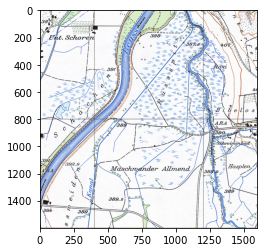

In [4]:
# setting the origin
y_shift = 9 # cells from north to south
x_shift = 0 # cells from east to west
y_inc = 2
x_inc = 2
image_cropped = cv2.imread(images[2])[y_shift*800:int(y_shift+y_inc)*800,
                                      x_shift*800:int(x_shift+x_inc)*800,
                                      :]
image_cropped_converted = cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB)
plt.imshow(image_cropped_converted)
cv2.imwrite(os.path.join(os.getcwd(),"sample","cropped_sample.png"),image_cropped,)

### Workflow

In [5]:
# template_dir = './boilerplate_images/template/'
# image_path = os.path.join(os.getcwd(),'boilerplate_images','sample','sample1.jpg')

template_dir = './template/'
image_path = os.path.join(os.getcwd(),'sample','newimage.png')
image_path_cropped = os.path.join(os.getcwd(),"sample","cropped_sample.png")
dataset = ImageDataset_og(Path(template_dir), image_path_cropped)
# dataset = ImageDataset_og_mod(Path(template_dir), 
#                                    image_cropped_converted,
#                                    thresh_csv=None, 
#                                    transform=None, 
#                                    image_array=True, 
#                                    image_name_input="cropped_1092_1990")

### Running QATM

#### Single Alpha

In [5]:
alpha_val = 25
model = CreateModel(model=models.vgg19(pretrained=True).features, alpha=alpha_val, use_cuda=False)

1
1
1
1
1
1
1


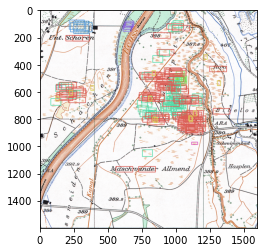

In [10]:
scores, w_array, h_array, thresh_list = run_multi_sample(model, dataset)
# scores, w_array, h_array, thresh_list = run_one_sample(model, dataset, dataset.image, dataset.image_name)
boxes, indices = nms_multi(scores, w_array, h_array, thresh_list)

d_img = plot_result_multi(dataset.image_raw, boxes, indices, show=True,
                          save_name=f'notebooks/evaluate/alpha_testing/result_sample_single_{alpha_val}.png')



#### Alpha Loop

In [11]:
def run_qatm(alpha_val,dataset):
    model = CreateModel(model=models.vgg19(pretrained=True).features, alpha=alpha_val, use_cuda=False)

    scores, w_array, h_array, thresh_list = run_multi_sample(model, dataset)
    # scores, w_array, h_array, thresh_list = run_one_sample(model, dataset, dataset.image, dataset.image_name)
    boxes, indices = nms_multi(scores, w_array, h_array, thresh_list)
    plot_result_multi(dataset.image_raw, boxes, indices, show=False,
                      save_name=f'notebooks/evaluate/alpha_testing/loop/result_sample_loop_{alpha_val}.png')
    np.save(f'notebooks/evaluate/alpha_testing/loop/score_arrays/result_sample_scores_{alpha_val}',
            scores)


In [6]:
alpha_range = range(31,32)

In [13]:
%%capture --no-stderr

# run QATM through multiple alphas


for alpha_val in tqdm(alpha_range):
    run_qatm(alpha_val,dataset)

  0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/cartography/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1647804319176/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 1/1 [00:14<00:00, 14.62s/it]


In [7]:
%%capture --no-stderr

# create masks for multiple alphas
for alpha_val in tqdm(alpha_range):
    #Turning it to a binary image
    scores = np.load(f'notebooks/evaluate/alpha_testing/loop/score_arrays/result_sample_scores_{alpha_val}.npy')
    scorecopy = scores[0]
    mask1 = scorecopy>0.0055
    scorecopy[mask1] = 255
    mask_3d = scorecopy[:, :, None] * np.ones(3, dtype=int)[None, None, :]
    # save image
    mask_path = os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing','loop','masks',f"result_sample_loop_{alpha_val}.png")
    cv2.imwrite(mask_path,mask_3d)

100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


In [8]:
%%capture --no-stderr

# make shapes for multiple alphas

sheet_official = "1111_1988"
epsg = "21781"
sheet_number = 'sheet2'

for alpha_val in tqdm(alpha_range):
    geo_mask_dest = os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing','loop','geotif',f"geomask_{alpha_val}.tif")
    masked_image_path = os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing','loop','masks',f"result_sample_loop_{alpha_val}.png")
    original_tile = f"/Users/jmccarty/Data/220206_ReTo_carto/template_matching/tif_files/LKg_{sheet_official}.tif"
    shape_destination = os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing','loop','shapes',f"geomask_shape_{alpha_val}.geojson")

    og = rasterio.open(original_tile, 'r')
    og_transform = og.transform
    og_x = og_transform[2]
    og_y = og_transform[5]

    main_shape_create(sheet_official,
                    epsg,
                    geo_mask_dest,
                    masked_image_path,
                    original_tile,
                    n_cores,
                    chunk_size,
                    shape_destination,
                    new_x=og_x + (int(x_shift*(800*1.25))),
                    new_y=og_y - (int((0+y_shift)*(800*1.25))),
                    new_tform=True)

  0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/cartography/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/cartography/lib/python3.8/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cartography/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
100%|██████████| 1/1 [00:18<00:00, 18.31s/it]


### Evaluation Single

True

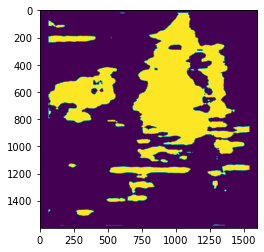

In [9]:

#Turning it to a binary image
scorecopy = scores[0]
mask1 = scorecopy>0.0055
scorecopy[mask1] = 255
plt.imshow(scorecopy)

mask_3d = scorecopy[:, :, None] * np.ones(3, dtype=int)[None, None, :]

# save image
mask_path = os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing',f"mask_{alpha_val}.png")
cv2.imwrite(mask_path,mask_3d)

#### Making Shapes

/opt/homebrew/Caskroom/miniforge/base/envs/cartography/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


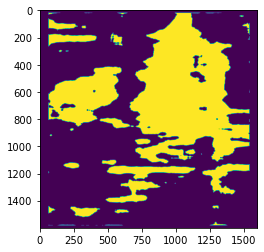

In [14]:
import rioxarray as rxr
import rasterio
mask_r = rasterio.open(mask_path, 'r')
plt.imshow(mask_r.read(3))

In [ ]:
sheet_official = "1111_1988"
epsg = "21781"
sheet_number = 'sheet2'

geo_mask_dest = os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing',f"geomask_{alpha_val}.tif")
masked_image_path = os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing',f"mask_{alpha_val}.png")
original_tile = f"/Users/jmccarty/Data/220206_ReTo_carto/template_matching/tif_files/LKg_{sheet_official}.tif"
shape_destination = os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing',f"geomask_shape_{alpha_val}.geojson")

og = rasterio.open(original_tile, 'r')
og_transform = og.transform
og_x = og_transform[2]
og_y = og_transform[5]

main_shape_create(sheet_official,
                  epsg,
                  geo_mask_dest,
                  masked_image_path,
                  original_tile,
                  n_cores,
                  chunk_size,
                  shape_destination,
                  new_x=og_x + (int(x_shift*(800*1.25))),
                  new_y=og_y - (int((0+y_shift)*(800*1.25))),
                  new_tform=True)

### MAE Multiple

In [16]:
%%capture --no-stderr

error_dict = {}

for alpha_val in tqdm(range(5,46)):
    ref_shape_path = os.path.join(REF_ROOT,f"LKg_{sheet}",f"wetlands_{sheet}.shp")
    ref_shape = gpd.read_file(ref_shape_path)
    # ref_image_path = os.path.join(DATA_ROOT, f"LKg_{sheet}.tif")
    ref_image_path = os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing',f"sample_clip_{sheet}.tif")
    qatm_shape_path = os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing','loop','shapes',f"geomask_shape_{alpha_val}.geojson")
    qatm_shape = gpd.read_file(qatm_shape_path)
    output_ref_mask_path = os.path.join(RESULTS_PATH,'alpha_testing',f"{sheet}_ref_shp_mask.tif")
    output_qatm_mask_path = os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing','loop','geotif',f"{sheet}_qatm_shp_mask_{alpha_val}.tif")

    if gpd.read_file(qatm_shape_path)['geometry'].iloc[0]==None:
        error_dict[f'{alpha_val}'] = np.nan
    else:    
        # generate mask files for the qatm_shapes
        generate_mask(ref_image_path,qatm_shape_path,output_qatm_mask_path)
        # generate mask files for the original shapes
        generate_mask(ref_image_path,ref_shape_path,output_ref_mask_path)

        # load the recently created masks
        ref_mask = rxr.open_rasterio(output_ref_mask_path)
        ref_mask_val = ref_mask.values[0]
        ref_mask_nan = np.where(ref_mask_val==0,np.nan,1)

        qatm_mask = rxr.open_rasterio(output_qatm_mask_path)
        if qatm_mask[0].shape!=ref_mask[0].shape:
            qatm_mask_val = qatm_mask.values[0][y_shift*800:int(y_shift+y_inc)*800,
                                                x_shift*800:int(x_shift+x_inc)*800]
        else:
            qatm_mask_val = qatm_mask.values[0]
        qatm_mask_nan = np.where(qatm_mask_val==0,np.nan,1) 

        cell_mults = calc_cell_multipliers(1600,1600)
        cell_mult = cell_mults[7]
        indices = calc_cell_indices(cell_mult,ref_mask_nan,(1.25,1.25))
        err_arr = calc_error_arr(qatm_mask_val,ref_mask_val,cell_mult,indices)
        np.save(os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing','loop','error_arrays',f'err_arr_{alpha_val}'),err_arr)
        mean_error = np.nanmean(err_arr**2)
        error_dict[f'{alpha_val}'] = mean_error

  0%|          | 0/41 [00:00<?, ?it/s]/var/folders/ww/12z6q0wj4c527ftkk7sxqb680000gp/T/ipykernel_54641/3305010180.py:103: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in row['geometry']:
/var/folders/ww/12z6q0wj4c527ftkk7sxqb680000gp/T/ipykernel_54641/3305010180.py:103: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in row['geometry']:
/opt/homebrew/Caskroom/miniforge/base/envs/cartography/lib/python3.8/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cartography/lib/python3.8/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rec

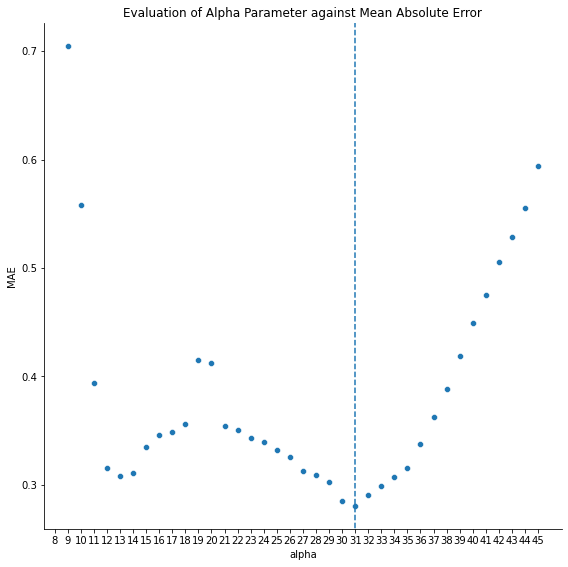

In [59]:
mae_df = pd.DataFrame(pd.Series(error_dict,index=error_dict.keys()).rename("MAE"))
mae_df.reset_index(inplace=True)
mae_df.rename(columns={'index':'alpha'},inplace=True)

fig, ax = plt.subplots(figsize=(8,8*.9973))
plt.vlines(26,0,1,linestyles='dashed')
# plt.hlines(error_dict[str(31)],0,26)
sns.scatterplot(x=mae_df['alpha'],y=mae_df['MAE'],ax=ax)
ax.set_title('Evaluation of Alpha Parameter against Mean Absolute Error')
sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing','figures','alpha_MAE.png'),dpi=144)

([], [])

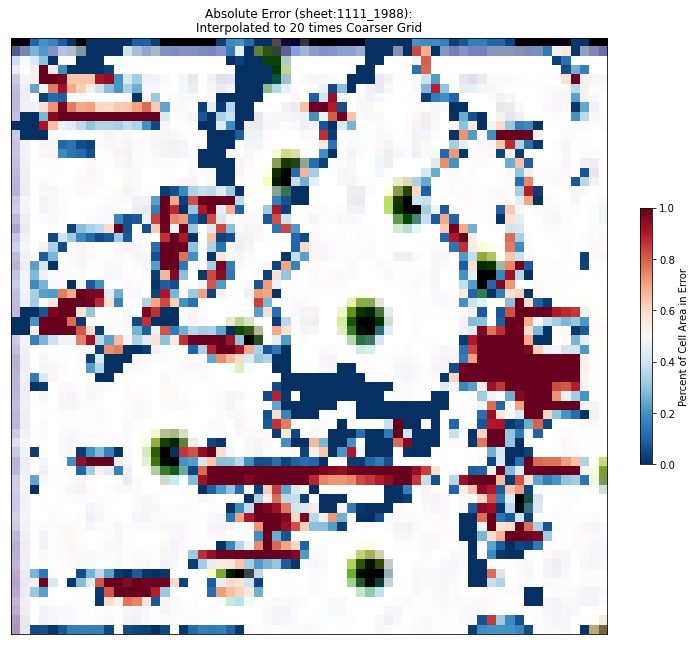

In [189]:
fig, ax = plt.subplots(figsize=(10,10))

# make a color map of fixed colors
cmap = "RdBu_r"
ax.imshow(image_cropped_converted,zorder=1)
im = ax.imshow(err_arr,
               cmap=cmap, vmin=0, vmax=1, zorder=2, interpolation="none")

ax.set_title(f"Absolute Error (sheet:{sheet}):"
             "\n"
             f"Interpolated to {cell_mult} times Coarser Grid") 
fig.colorbar(im, orientation="vertical",fraction=0.02,label="Percent of Cell Area in Error")

plt.tight_layout()
plt.xticks([])
plt.yticks([])

# fig.savefig(os.path.join(RESULTS_PATH,f"error_map_{sheet}.png"),dpi=144)


#### Clip Base Image

In [12]:
new_x=og_x + (int(x_shift*(800*1.25)))
new_y=og_y - (int((0+y_shift)*(800*1.25)))

geometries = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [new_x, new_y],
            [new_x+(x_inc*(800*1.25)), new_y],
            [new_x+(x_inc*(800*1.25)), new_y-(y_inc*(800*1.25))],
            [new_x, new_y-(y_inc*(800*1.25))],
        ]]
    }
]


data = rasterio.open(os.path.join(DATA_ROOT, f"LKg_{sheet}.tif"))
out_img, out_transform = rasterio.mask.mask(data, shapes=geometries, crop=True)
out_meta = data.meta.copy()
epsg_code = int(data.crs.data['init'][5:])
out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform})
                    #  "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
out_tif = os.path.join(os.getcwd(),'notebooks','evaluate','alpha_testing',f"sample_clip_{sheet}.tif")
with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)

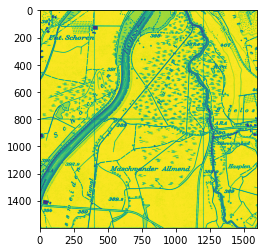

In [15]:
plt.imshow(rasterio.open(out_tif).read(1))

#### Back to MAE